# <center> **DistilBert-Based Sentiment Classification for Food Insecurity Tweets**</center>
<center>(DistilBert-based Sentiment Classification & Model Evaluation)</center>

### 📌 Notebook Overview
This notebook builds upon the initial data cleaning and exploratory analysis work by training a powerful DistilBert model to classify tweets related to food security into multiple sentiment categories. We will carefully prepare the data, handle imbalanced classes, fine-tune a pretrained DistilBert, and evaluate the model’s performance using robust metrics.

**🎯 Goal ?** Fine-tune a DistilBert model on our cleaned and translated tweet dataset to accurately classify each tweet 

🔗 [Check out here: Data Cleaning & NLP Pipeline for Social Media Opinions on Food Security in Malaysia](https://www.kaggle.com/code/dhaouadiibtihel98/clean-data-sentiment-analysis-lda-topic-modeling/notebook#%F0%9F%94%8D-Step-3:-Load-and-Explore-the-Dataset)

### Key Steps & Workflow:
1. **🧹 Data Preparation & Encoding**
   * Encoding classes into numerical labels
   * Tokenization using DistilBertTokenizer from HuggingFace
   * Handling class imbalance using Weighted loss functions
   * Split the dataset into training, validation, and test sets
2. **🏗️ Building and Fine-tuning the DistilBert Classifier**
   * Load a pre-trained DistilBert model (distilbert-base-uncased)
   * Add a custom classification head for 4 sentiment classes
   * Use AdamW optimizer and learning rate scheduler for stable training
   * Fine-tune using our labeled tweets
3. **🔁 Training and Evaluation Loops**
   * Custom train_epoch() and eval_model() functions with metric tracking
   * Evaluation using accuracy, precision, recall, and F1-score (weighted to account for imbalance)
   * Integrated learning rate scheduling & optimizer tuning
4. **📈 Performance Visualization**
   * Plot detailed training and validation curves
   * Validating model performance to avoid overfitting
   * Visualize performance using Confusion Matrix and ROC Curve.

## **📚 Import Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss

from collections import Counter

2025-06-23 19:32:43.002350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750707163.238341      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750707163.305870      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

Using device: cuda


## **🧹 Data Preparation & Encoding**

### 🔍 Load Dataset

In [3]:
path = '/kaggle/input/sentiment-analysis-for-food-insecurity/food_security_processed_data.csv'
df = pd.read_csv(path)
df = df.drop_duplicates(['Cleaned_Text'] , keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30760 entries, 0 to 34102
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Datetime         30760 non-null  object 
 1   Username         30760 non-null  object 
 2   Text             30760 non-null  object 
 3   Location         30760 non-null  object 
 4   translated_Text  30760 non-null  object 
 5   Cleaned_Text     30759 non-null  object 
 6   sentiment_score  30760 non-null  float64
 7   sentiment_label  30760 non-null  object 
 8   risk_level       30760 non-null  object 
 9   assigned_topic   30760 non-null  object 
 10  risk_score       30760 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 2.8+ MB


In [4]:
#Calculate the length of each Cleaned_Text
df['text_length'] = df['Cleaned_Text'].fillna('').apply(lambda x: len(x.strip().split()))

# Filter the DataFrame to keep only tweets with text length ≤ 20 characters
df_filtered = df[df['text_length'] <= 20]

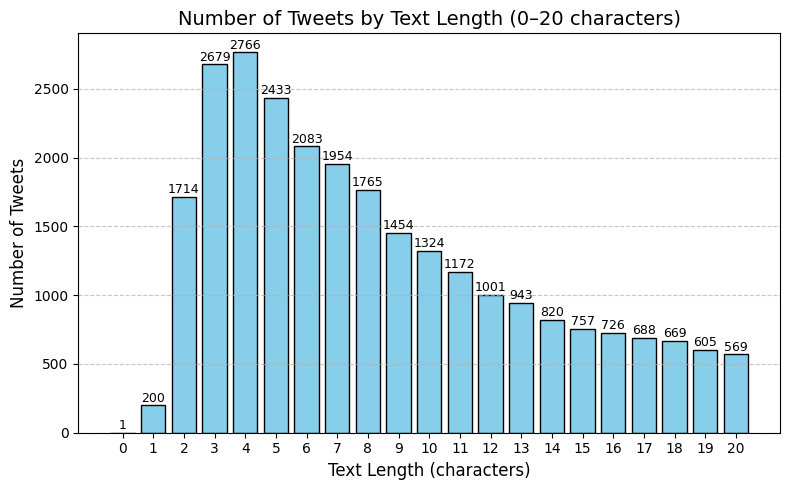

In [5]:
# Count how many tweets have each specific text length (0 to 20 characters)
length_counts = df_filtered['text_length'].value_counts().sort_index()

# Ensure all lengths from 0 to 20 are present (even if count = 0)
all_lengths = list(range(0, 21))
counts = [length_counts.get(i, 0) for i in all_lengths]

# Plot using bar chart instead of hist for better control over labels
plt.figure(figsize=(8, 5))
bars = plt.bar(all_lengths, counts, color='skyblue', edgecolor='black')

# Add number of tweets on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, str(height),
             ha='center', va='bottom', fontsize=9)

# Set plot details
plt.title("Number of Tweets by Text Length (0–20 characters)", fontsize=14)
plt.xlabel("Text Length (characters)", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(all_lengths)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
df = df[df['text_length'] > 1]

In [7]:
df.head(5)

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text,sentiment_score,sentiment_label,risk_level,assigned_topic,risk_score,text_length
0,2022-02-01 00:18:19,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungry r perception action terengganu,0.0000,negative,Medium,Food Insecurity,1,5
1,2022-02-01 00:20:14,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",Unknown,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morning blind siantar hungry want breakfas...,-0.3400,negative,Medium,Fasting and Food Access Challenges,1,10
2,2022-02-01 01:04:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungry wind already,0.0000,negative,Medium,Daily Hunger Struggles,1,3
3,2022-02-01 01:06:14,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morning clock thought breakfast breakfas...,0.0000,negative,Medium,Fasting and Food Access Challenges,1,14
4,2022-02-01 01:20:36,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowly rebuild pace got problem knee injury su...,-0.8481,very negative,High,Daily Hunger Struggles,2,11


### 🔢 Encode Classes into Numerical Labels

Before training, we need to convert the categorical **sentiment_label** into **numerical** form using **label encoding**.

In [8]:
# Map original sentiment labels to binary classes
df['binary_sentiment'] = df['sentiment_label'].replace({
    'very negative': 'negative',
    'very positive': 'positive'
})

In [9]:
# Encode the sentiment labels into numerical format
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['binary_sentiment'])
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Sentiment classes:", class_mapping)

Sentiment classes: {'negative': 0, 'positive': 1}


In [10]:
print(df['label_encoded'].value_counts())

label_encoded
0    18679
1    11880
Name: count, dtype: int64


### 🧼 Tokenization and Padding with DistilBert Tokenizer

In [11]:
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

token_lengths = []
for text in tqdm(df['Cleaned_Text'].fillna("")):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    token_lengths.append(len(tokens))

print("Max length:", np.max(token_lengths))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

100%|██████████| 30559/30559 [00:08<00:00, 3515.24it/s]

Max length: 81


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


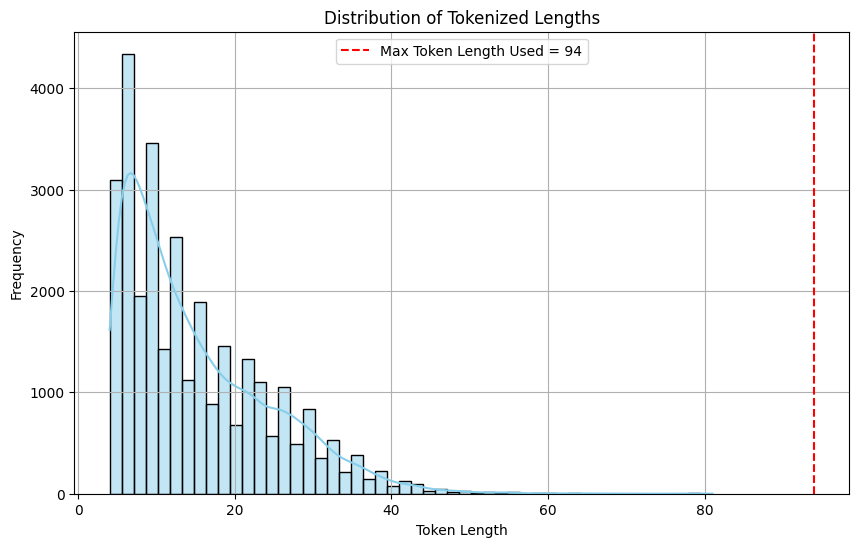

In [12]:
# Plot histogram of token lengths
plt.figure(figsize=(10,6))
sns.histplot(token_lengths, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Tokenized Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.axvline(x=94, color='red', linestyle='--', label='Max Token Length Used = 94')
plt.legend()
plt.show()

In [13]:
# Tokenize and encode the text
encoded_inputs = tokenizer(
    df['Cleaned_Text'].fillna("").tolist(),  # Convert Series to list and handle NaNs
    padding=True,
    truncation=True,
    return_tensors='pt',  # Return PyTorch tensors
    max_length=94
)
encoded_inputs['input_ids']

tensor([[ 101, 7501, 1054,  ...,    0,    0,    0],
        [ 101, 2028, 2851,  ...,    0,    0,    0],
        [ 101, 7501, 3612,  ...,    0,    0,    0],
        ...,
        [ 101, 7501, 2292,  ...,    0,    0,    0],
        [ 101, 3435, 2075,  ...,    0,    0,    0],
        [ 101, 9302, 3433,  ...,    0,    0,    0]])

In [14]:
# Define inputs and targets
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']
labels = torch.tensor(df['label_encoded'].values)

# Vérification des formes
print("input_ids shape:", input_ids.shape)
print("attention_masks shape:", attention_masks.shape)
print("labels shape:", labels.shape)

input_ids shape: torch.Size([30559, 81])
attention_masks shape: torch.Size([30559, 81])
labels shape: torch.Size([30559])


### ⚖️ Handling Class Imbalance 

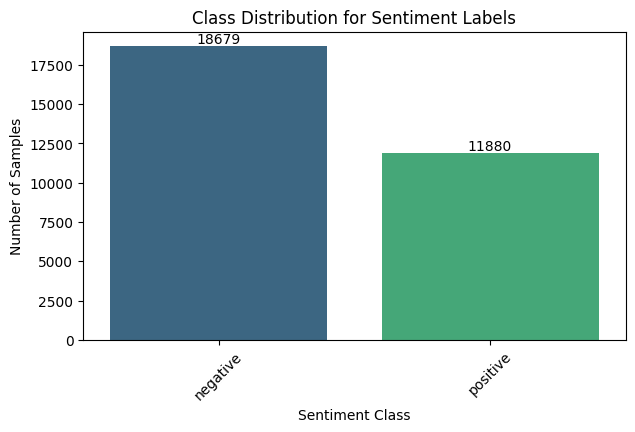

In [15]:
# Plot class distribution to check for imbalance
class_counts = df['binary_sentiment'].value_counts()

plt.figure(figsize=(7,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution for Sentiment Labels')
plt.ylabel('Number of Samples')
plt.xlabel('Sentiment Class')
plt.xticks(rotation=45)
for i, count in enumerate(class_counts.values):
    plt.text(i, count + max(class_counts.values)*0.01, str(count), ha='center')
plt.show()

📊 To address the issue of class imbalance in our sentiment labels, we compute **class weights** using `sklearn`’s `compute_class_weight` function. This ensures that underrepresented classes are not ignored during training, and the model is penalized more when it misclassifies minority classes. 

These computed weights will later be incorporated into our loss function (`CrossEntropyLoss`) to guide the model towards fairer predictions across all sentiment categories.


In [16]:
# Compute class weights for sentiment
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_encoded']),
    y=df['label_encoded']
)
class_weights_dict = {i : weight for i, weight in enumerate(class_weights)}
print("Class weights (sentiment):", class_weights_dict)

Class weights (sentiment): {0: 0.8180041758124097, 1: 1.2861531986531987}


### 🔀 Split Dataset into Train, Validation and Test Sets

We split the data into **70% training**, **20% validation**, and **10% test sets** with stratification to keep class distribution consistent.

In [17]:
# Define inputs and targets
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']
labels = df['label_encoded'].values

# Train-test split
X_train, X_temp, y_train, y_temp, mask_train, mask_temp = train_test_split(
    input_ids, labels, attention_masks, test_size=0.3, random_state=42,shuffle=True, stratify=labels)

# Validation-test split
X_val, X_test, y_val, y_test, mask_val, mask_test = train_test_split(
    X_temp, y_temp, mask_temp, test_size=0.3333, random_state=42, stratify=y_temp)

print(f"Training set size: {len(y_train)}")
print(f"Validation set size: {len(y_val)}")
print(f"Test set size: {len(y_test)}")

Training set size: 21391
Validation set size: 6112
Test set size: 3056


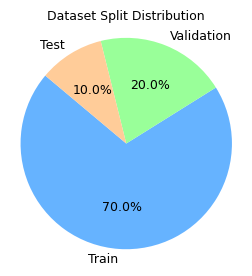

In [18]:
# Sizes of each dataset
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Train', 'Validation', 'Test']
colors = ['#66b3ff','#99ff99','#ffcc99']

plt.figure(figsize=(3,3))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 9})
plt.title('Dataset Split Distribution', fontsize=9)
plt.axis('equal')
plt.show()

## **🏗️ Building and Fine-tuning the DistilBert Classifier**


### **Define a Custom Dataset Class**

In [19]:
# Define Dataset class
class FoodSecurityDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

### **Create DataLoaders**

In [20]:
# Create datasets
train_dataset = FoodSecurityDataset(X_train, mask_train, y_train)
val_dataset = FoodSecurityDataset(X_val, mask_val, y_val)
test_dataset = FoodSecurityDataset(X_test, mask_test, y_test)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### **Load Pre-trained DistilBert Model for Classification**

In [21]:
# Load configuration and set dropout
config = DistilBertConfig.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(class_mapping),
    dropout=0.3,           # Dropout for the classifier head
    attention_dropout=0.2  # Dropout for attention layers
)

# Load DistilBert model for sequence classification (2 classes)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    config=config
)


model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.3, inplace=False)


In [22]:
# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model):,}")

Trainable parameters: 66,955,010


In [23]:
# Prepare optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

epochs = 7
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Class weights tensor
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = CrossEntropyLoss(weight=weights)

## **🔁 Training and Evaluation Loops**


### **Training & Evaluation Functions**

In [24]:
# Training function
def train_epoch(model, dataloader, loss_fn, optimizer, scheduler):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return avg_loss, accuracy, precision, recall, f1

In [25]:
# Evaluation function
def eval_model(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds


### **Train the Model**

In [26]:
# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

best_val_f1 = float('-inf')
patience = 3  # number of epochs to wait before stopping
early_stop_counter = 0
best_epoch = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(model, train_loader, loss_fn, optimizer, scheduler)
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = eval_model(model, val_loader, loss_fn)

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)
    history['val_f1'].append(val_f1)

     # ---- Early Stopping Check ----
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stop_counter = 0
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pt')  # save best model
    else:
        early_stop_counter += 1
        print(f"Validation F1 did not improve. Early stop counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            epochs = epoch + 1
            print("🛑 Early stopping triggered.")
            break

model.load_state_dict(torch.load('best_model.pt'))


Epoch 1/7


Evaluating: 100%|██████████| 191/191 [00:07<00:00, 24.96it/s]


Train Loss: 0.4110, Accuracy: 0.8113, Precision: 0.8101, Recall: 0.8113, F1: 0.8085
Val   Loss: 0.2626, Accuracy: 0.8894, Precision: 0.8892, Recall: 0.8894, F1: 0.8886

Epoch 2/7


Evaluating: 100%|██████████| 191/191 [00:07<00:00, 25.37it/s]


Train Loss: 0.2631, Accuracy: 0.8927, Precision: 0.8923, Recall: 0.8927, F1: 0.8923
Val   Loss: 0.2154, Accuracy: 0.9110, Precision: 0.9107, Recall: 0.9110, F1: 0.9107

Epoch 3/7


Evaluating: 100%|██████████| 191/191 [00:07<00:00, 25.43it/s]


Train Loss: 0.2077, Accuracy: 0.9177, Precision: 0.9175, Recall: 0.9177, F1: 0.9175
Val   Loss: 0.1975, Accuracy: 0.9195, Precision: 0.9194, Recall: 0.9195, F1: 0.9194

Epoch 4/7


Evaluating: 100%|██████████| 191/191 [00:07<00:00, 25.47it/s]


Train Loss: 0.1834, Accuracy: 0.9297, Precision: 0.9296, Recall: 0.9297, F1: 0.9296
Val   Loss: 0.1927, Accuracy: 0.9231, Precision: 0.9241, Recall: 0.9231, F1: 0.9234

Epoch 5/7


Evaluating: 100%|██████████| 191/191 [00:07<00:00, 25.46it/s]


Train Loss: 0.1632, Accuracy: 0.9376, Precision: 0.9375, Recall: 0.9376, F1: 0.9375
Val   Loss: 0.1828, Accuracy: 0.9280, Precision: 0.9280, Recall: 0.9280, F1: 0.9280

Epoch 6/7


Evaluating: 100%|██████████| 191/191 [00:07<00:00, 25.57it/s]


Train Loss: 0.1521, Accuracy: 0.9425, Precision: 0.9424, Recall: 0.9425, F1: 0.9425
Val   Loss: 0.1851, Accuracy: 0.9264, Precision: 0.9264, Recall: 0.9264, F1: 0.9264
Validation F1 did not improve. Early stop counter: 1/3

Epoch 7/7


Evaluating: 100%|██████████| 191/191 [00:07<00:00, 25.53it/s]


Train Loss: 0.1404, Accuracy: 0.9461, Precision: 0.9460, Recall: 0.9461, F1: 0.9460
Val   Loss: 0.1847, Accuracy: 0.9280, Precision: 0.9281, Recall: 0.9280, F1: 0.9281


<All keys matched successfully>

## **📈 Performance Visualization**

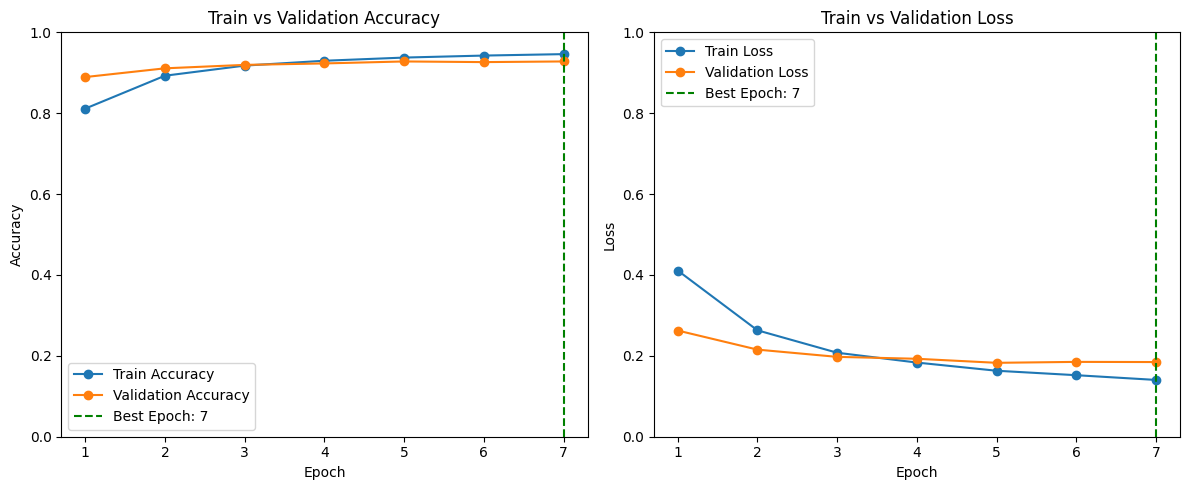

In [27]:
epochs_range = range(1, len(history['train_acc']) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy', marker='o')
plt.axvline(best_epoch, color='green', linestyle='--', label=f'Best Epoch: {best_epoch}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.ylim(0, 1)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='o')
plt.axvline(best_epoch, color='green', linestyle='--', label=f'Best Epoch: {best_epoch}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

### Final Evaluation on Test Set + Visualization

In [28]:
# Final evaluation on test set
test_loss, test_acc, test_prec, test_rec, test_f1, y_true, y_pred = eval_model(model, test_loader, loss_fn)
print(f"\nTest Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}")

Evaluating: 100%|██████████| 96/96 [00:03<00:00, 26.37it/s]


Test Loss: 0.1977, Accuracy: 0.9264, Precision: 0.9270, Recall: 0.9264, F1: 0.9266


In [29]:
print("\nTest Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


Test Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.93      0.94      1868
    positive       0.89      0.92      0.91      1188

    accuracy                           0.93      3056
   macro avg       0.92      0.93      0.92      3056
weighted avg       0.93      0.93      0.93      3056



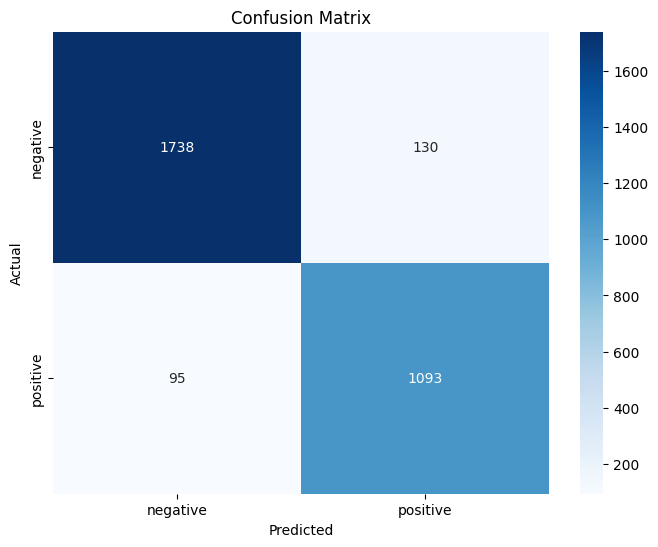

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

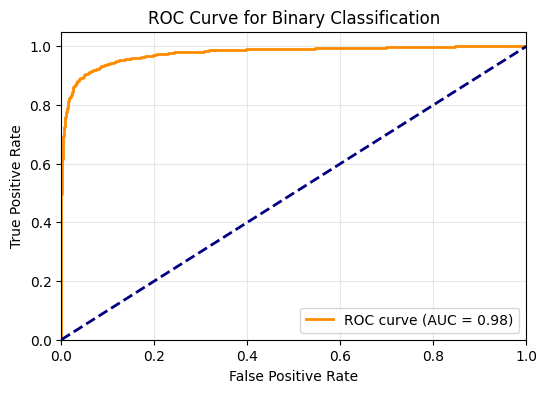

In [31]:
y_true_bin = np.array(y_true) 

# Get model predictions (logits)
model.eval()
all_logits = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_logits.append(logits.detach().cpu().numpy())

# Convert logits to probabilities using softmax or sigmoid
all_logits = np.vstack(all_logits)

# If you have 2 output units, use softmax and take prob for class 1
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()[:, 1]  # Probability of positive class

# Compute ROC curve and ROC-AUC
fpr, tpr, _ = roc_curve(y_true_bin, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

##  🧪 Test the Fine-Tuned Model on New Example Tweets


In [32]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 6.7 MB/s eta 0:00:00


In [33]:
import cloudpickle
pipeline_path = "/kaggle/input/sentiment-analysis-text-preprocessor-pipeline/scikitlearn/default/2/text_preprocessor_pipeline.pkl"
# Load the pipeline
with open(pipeline_path, "rb") as f:
    text_pipeline = cloudpickle.load(f)

In [34]:
# example tweets
sample_tweets = [
    # Negative (short)
    "No food at home again. Feeling hopeless. 😞",
    
    # Positive (long)
    "Thanks to the generous volunteers, our community now has access to fresh meals every day, which is a blessing beyond words! 🙏❤️",
    
    # Negative (long)
    "The prices for basic groceries have doubled this month. Many families in my neighborhood are struggling to put food on the table, and it's heartbreaking to witness.",
    
    # Positive (short)
    "Got my free lunch today, feeling grateful! 😊",
    
    # Negative (short)
    "Skipped dinner again, no money left for food.",
    
    # Positive (long)
    "Amazing support from local charities providing food packages to the vulnerable. It really makes a difference in people's lives. #ThankYou",
    
    # Negative (long)
    "The drought has destroyed the crops, leaving farmers with no income and communities facing severe food shortages.",
    
    # Positive (short)
    "Fresh fruits and veggies at the food bank today! 🥳",
    
    # Negative (short)
    "Empty fridge, empty stomach.",
    
    # Positive (long)
    "Community kitchens are opening up and feeding hundreds daily. It's inspiring to see people come together to fight hunger and support each other."
]

# Clean the examples
cleaned_tweets = text_pipeline.transform(sample_tweets)

In [35]:
# Tokenize for BERT
encoded = tokenizer(
    cleaned_tweets,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=94
)

In [36]:
# Move tensors to device
input_ids = encoded['input_ids'].to(device)
attention_mask = encoded['attention_mask'].to(device)

# Set model to eval mode and predict
model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

In [37]:
label_mapping = {
    0: "Negative",
    1: "Positive"
}

# Display predictions
for tweet, cleaned, label in zip(sample_tweets, cleaned_tweets, predictions):
    print(f"Tweet     : {tweet}")
    print(f"cleaned     : {cleaned}")
    print(f"Predicted : {label_mapping[label]}")
    print("-" * 50)

Tweet     : No food at home again. Feeling hopeless. 😞
cleaned     : food home feeling hopeless
Predicted : Negative
--------------------------------------------------
Tweet     : Thanks to the generous volunteers, our community now has access to fresh meals every day, which is a blessing beyond words! 🙏❤️
cleaned     : thanks generous volunteer community access fresh meal every day blessing beyond word
Predicted : Positive
--------------------------------------------------
Tweet     : The prices for basic groceries have doubled this month. Many families in my neighborhood are struggling to put food on the table, and it's heartbreaking to witness.
cleaned     : price basic grocery doubled month many family neighborhood struggling put food table heartbreaking witness
Predicted : Negative
--------------------------------------------------
Tweet     : Got my free lunch today, feeling grateful! 😊
cleaned     : got free lunch today feeling grateful
Predicted : Positive
---------------------

In [38]:
from IPython.display import display

# Prepare results in a DataFrame
results_df = pd.DataFrame({
    "Original Tweet": sample_tweets,
    "Cleaned Tweet": cleaned_tweets,
    "Predicted Label": [label_mapping[label] for label in predictions]
})

# Define color function
def highlight_sentiment(val):
    color = 'black'
    background = 'white'
    if val == "Positive":
        background = '#d4edda'  # light green
        color = '#155724'
    elif val == "Negative":
        background = '#f8d7da'  # light red
        color = '#721c24'
    return f'background-color: {background}; color: {color}; font-weight: bold;'

# Display styled DataFrame
styled_df = results_df.style.applymap(highlight_sentiment, subset=["Predicted Label"])
display(styled_df)

/tmp/ipykernel_19/1502671688.py:23: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = results_df.style.applymap(highlight_sentiment, subset=["Predicted Label"])


,Original Tweet,Cleaned Tweet,Predicted Label
0,No food at home again. Feeling hopeless. 😞,food home feeling hopeless,Negative
1,"Thanks to the generous volunteers, our community now has access to fresh meals every day, which is a blessing beyond words! 🙏❤️",thanks generous volunteer community access fresh meal every day blessing beyond word,Positive
2,"The prices for basic groceries have doubled this month. Many families in my neighborhood are struggling to put food on the table, and it's heartbreaking to witness.",price basic grocery doubled month many family neighborhood struggling put food table heartbreaking witness,Negative
3,"Got my free lunch today, feeling grateful! 😊",got free lunch today feeling grateful,Positive
4,"Skipped dinner again, no money left for food.",skipped dinner money left food,Negative
5,Amazing support from local charities providing food packages to the vulnerable. It really makes a difference in people's lives. #ThankYou,amazing support local charity providing food package vulnerable really make difference people life,Positive
6,"The drought has destroyed the crops, leaving farmers with no income and communities facing severe food shortages.",drought destroyed crop leaving farmer income community facing severe food shortage,Negative
7,Fresh fruits and veggies at the food bank today! 🥳,fresh fruit veggie food bank today,Positive
8,"Empty fridge, empty stomach.",empty fridge empty stomach,Negative
9,Community kitchens are opening up and feeding hundreds daily. It's inspiring to see people come together to fight hunger and support each other.,community kitchen opening feeding hundred daily inspiring see people come together fight hunger support,Positive


## **1️⃣ Save model and tokenizer locally in Kaggle’s output directory**

In [39]:
# Save directory (Kaggle output folder)
save_path = "/kaggle/working/DistilBert_sentiment_model"

# Save model
model.save_pretrained(save_path)

# Save tokenizer as well (important for inference)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.save_pretrained(save_path)

('/kaggle/working/DistilBert_sentiment_model/tokenizer_config.json',
 '/kaggle/working/DistilBert_sentiment_model/special_tokens_map.json',
 '/kaggle/working/DistilBert_sentiment_model/vocab.txt',
 '/kaggle/working/DistilBert_sentiment_model/added_tokens.json')

### <center>🙏 *Thank You!* </center>
<center> Thank you for exploring this notebook! 💙 </center>
<center> If you found it helpful, please consider giving it an upvote 👍</center>
<center>----</center>

Feel free to leave comments, suggestions, or questions. I’d love to hear your feedback! 😊

👉 Don’t forget to check out **[Notebook 1: Data Cleaning & NLP Pipeline](https://www.kaggle.com/code/dhaouadiibtihel98/clean-data-sentiment-analysis-lda-topic-modeling/notebook#%F0%9F%94%8D-Step-3:-Load-and-Explore-the-Dataset)** if you haven’t already!